Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import json

Import available GPU benchmark data from .json

In [2]:
with open(r".\benchmark-raw.json", encoding="utf-8") as datafile:
    data = json.load(datafile)

Deepcoopy the original dataframe, and edit that one

In [3]:
cleaned_data = copy.deepcopy(data)
cleaned_data = cleaned_data["events"]
for obj in cleaned_data:
    del obj['program']
    del obj['source_id']
    del obj['id']

In [4]:
# Create a DataFrame from the parsed data. Faster than looping and deleting manually.
df = pd.DataFrame(data['events'])
df.drop(columns=["program","id","source_id"], inplace=True)
expanded = df['message'].str.split('|', expand=True)
df.drop(columns=["message"], inplace=True)
expanded.columns = ["timestamp","scores","sdver","sysinfo","torch","gpu", "xformers","model","user","val1","val2","val3"]
expanded = expanded[["scores","sdver","sysinfo","torch","gpu", "xformers","model"]]
result = pd.concat([df, expanded], axis=1)
result.head(1)

,generated_at,scores,sdver,sysinfo,torch,gpu,xformers,model
0,2023-02-20T06:57:04-05:00,7.2 / 8.1 / 8.84,updated:2023-02-19 hash:fc3e9e5d url:https://g...,host:wsl arch:x86_64 cpu:x86_64 system:Linux r...,torch:2.0.0.dev20230211+cu118 autocast half xf...,"device:NVIDIA GeForce RTX 3060 (1) (sm_90) (8,...",xformers none,sd-v15-runwayml.ckpt [cc6cb27103]


In [5]:
# Extract benchmark scores from the message field
scores = result['scores'].str.split(' / ', expand=True).apply(pd.to_numeric, errors="coerce")
result.drop(columns=["scores"], inplace=True)
scores.columns = [f'score_{i+1}' for i in range(scores.shape[1])]
# Calculate the mean benchmark score for each row
scores['best_score'] = scores.max(axis=1) 
scores['mean_score'] = scores.mean(axis=1) 
result = pd.concat([result, scores], axis=1)
result.head(1)

,generated_at,sdver,sysinfo,torch,gpu,xformers,model,score_1,score_2,score_3,score_4,score_5,best_score,mean_score
0,2023-02-20T06:57:04-05:00,updated:2023-02-19 hash:fc3e9e5d url:https://g...,host:wsl arch:x86_64 cpu:x86_64 system:Linux r...,torch:2.0.0.dev20230211+cu118 autocast half xf...,"device:NVIDIA GeForce RTX 3060 (1) (sm_90) (8,...",xformers none,sd-v15-runwayml.ckpt [cc6cb27103],7.2,8.1,8.84,NaN,NaN,8.84,8.245


In [6]:
# Extract the graphics card model 
result['model'] = result['gpu'].str.extract(r'device:(.+)')
mod_series = result['gpu'].str.extract(r'((?:NVIDIA|Tesla|Quadro|AMD|Intel)(?:.*?))?\(', expand=False)
ram = result['gpu'].str.extract(r'(\d+GB)', expand=False)
result['mod'] = mod_series
result['ram'] = ram
result.dropna(subset=['mod'], inplace=True)

# Define a function to fill missing VRAM values with the mode of non-missing values
def fill_vram(group):
    return group.fillna(group.mode().iloc[0])

# Fill missing VRAM values by device name using most common value (mode)
result["ram"] = result.groupby('mod')['ram'].transform(fill_vram)

result["device"] = result["mod"].str.strip() + " | " + result["ram"].str.strip()
result.drop(columns=["mod","ram","model"])
result.device.head()



0    NVIDIA GeForce RTX 3060 | 12GB
1    NVIDIA GeForce RTX 3080 | 10GB
2    NVIDIA GeForce RTX 3060 | 12GB
3    NVIDIA GeForce RTX 3060 | 12GB
4    NVIDIA GeForce RTX 3060 | 12GB
Name: device, dtype: object

In [7]:
# result = pd.DataFrame(copy.deepcopy(result))
# result["generated_at"] = pd.to_datetime(result["generated_at"])

In [17]:
# Group the data by graphics card model and calculate the mean benchmark score for each model
grouped = result.groupby('device')[['best_score']].agg(["mean","count"])
grouped.columns = grouped.columns.droplevel(0)
grouped = grouped.reset_index()
grouped = grouped.rename(columns={'mean': 'best_score_mean', 'count': 'best_score_count'})
grouped.head()

pd.set_option('display.max_rows', None)
df = grouped
filtered = df[~df['device'].str.contains('Tesla|Quadro|24|A100|A800|A600') & ~df['best_score_mean'].isna()]
filtered.to_csv("scores.csv")
# filtered.describe()
# filtered.head(150)


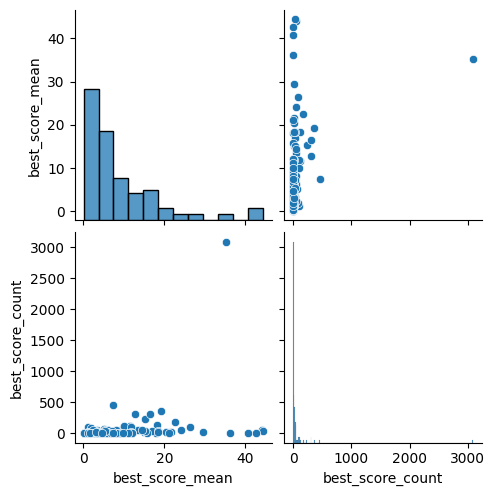

In [22]:
import seaborn
grouped.head()

# seaborn.displot(grouped['best_score_mean'], kde=True)
seaborn.pairplot(grouped)

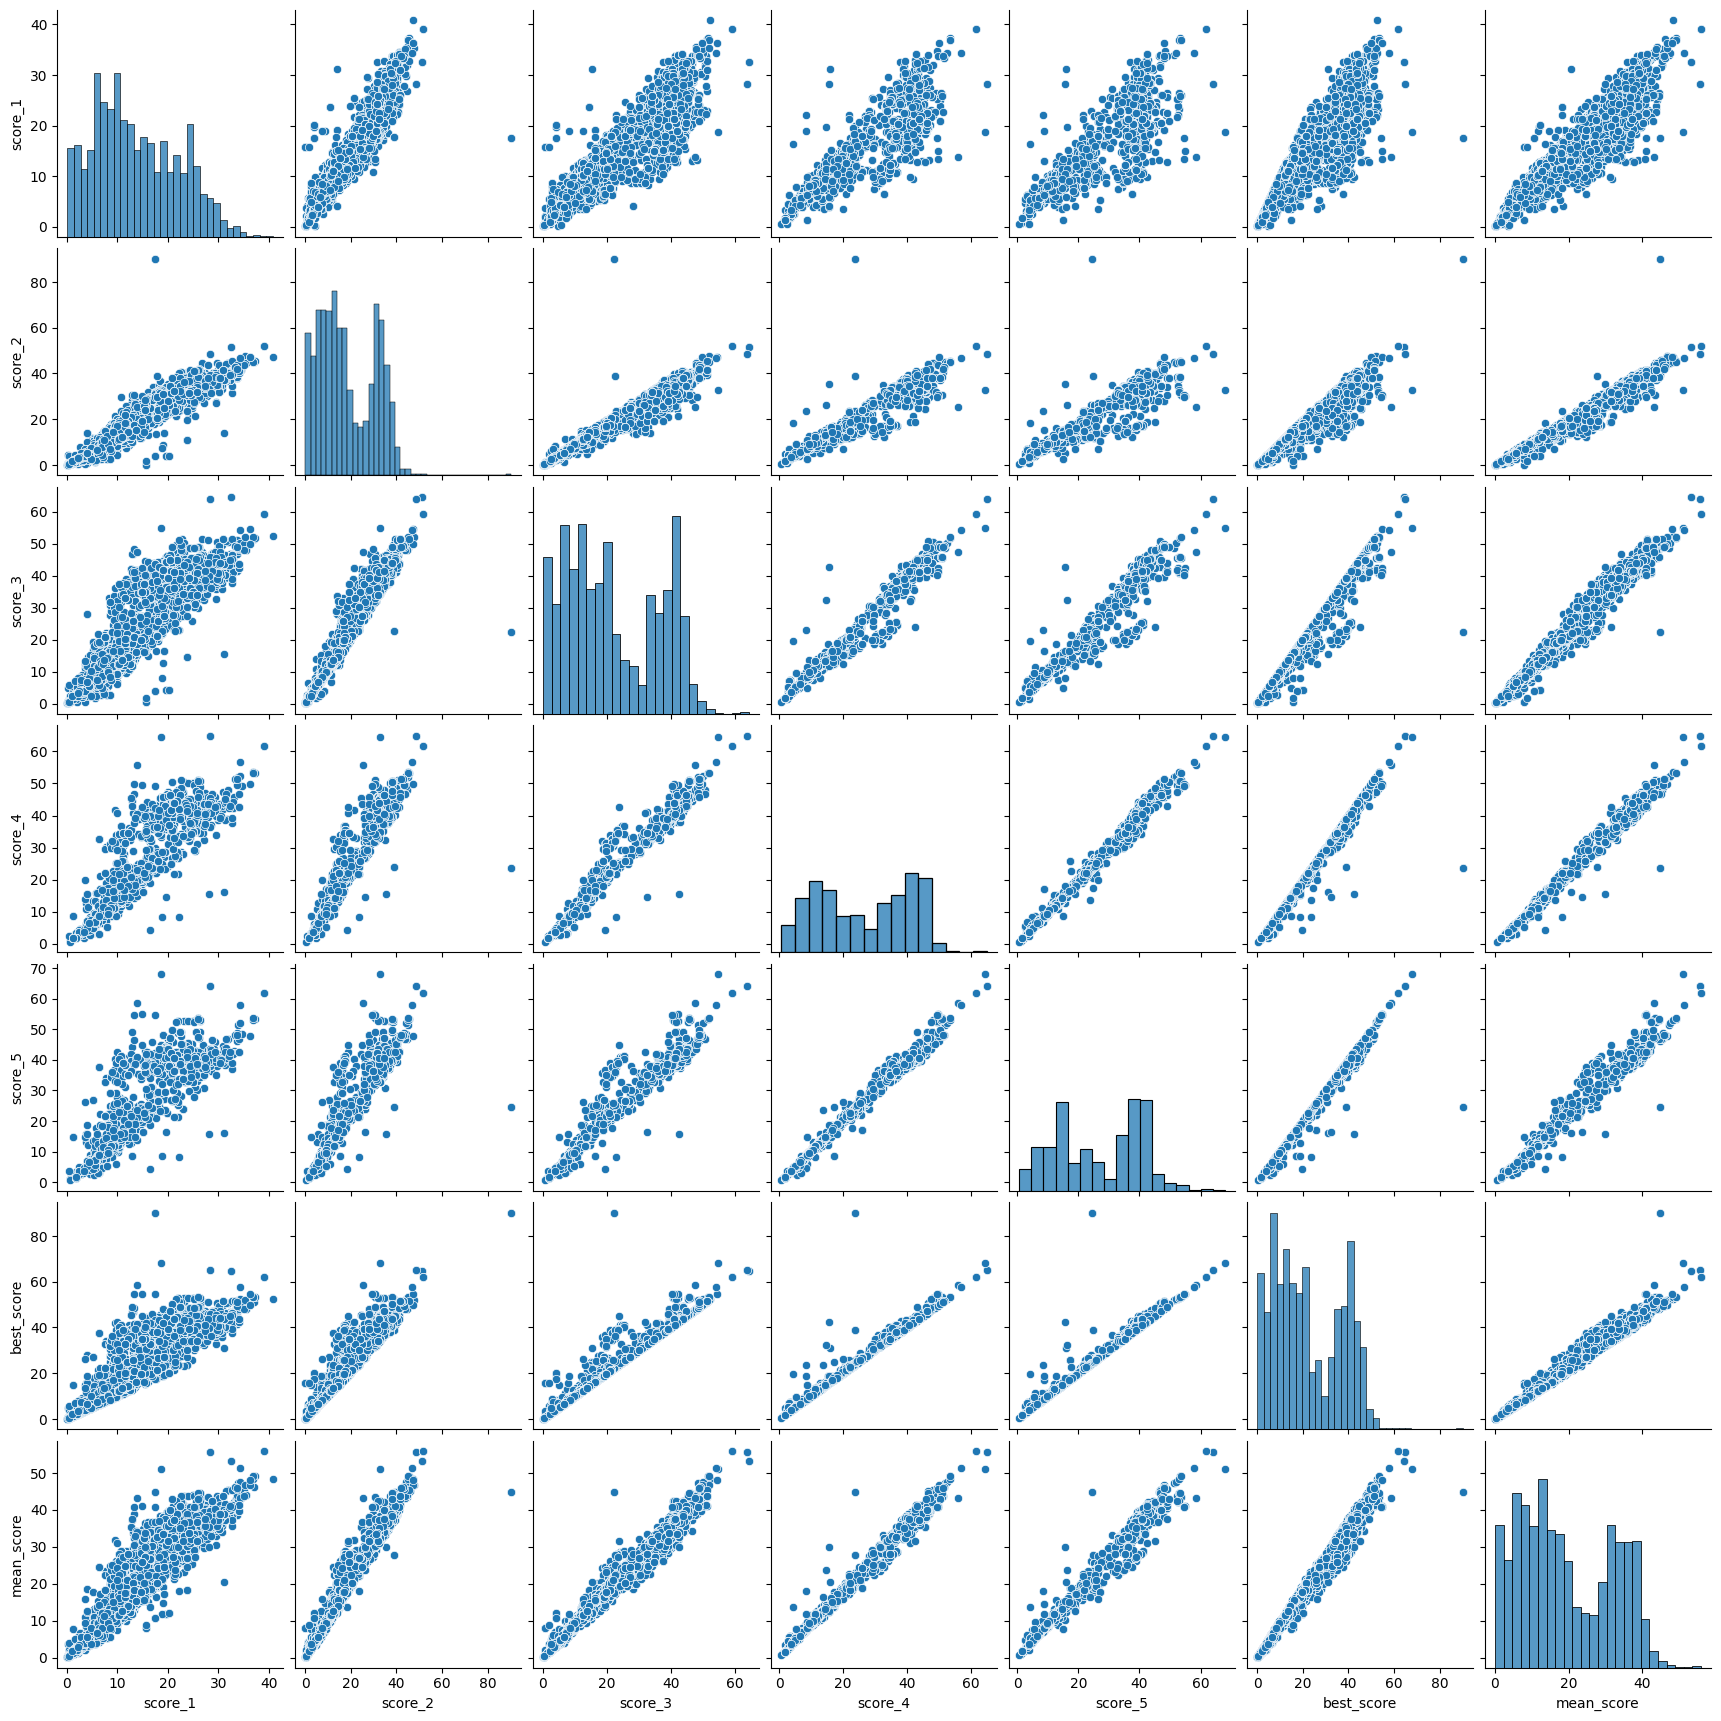

In [23]:
result.device.value_counts().head(5)

seaborn.pairplot(result)


In [10]:
# result = pd.DataFrame(copy.deepcopy(result))
# result["generated_at"] = pd.to_datetime(result["generated_at"])

In [11]:
# Merge the grouped data with the price list
price_list = pd.DataFrame({
    'model': ['GeForce RTX 3060', 'GeForce RTX 3070', 'GeForce RTX 3080'],
    'price': [268, 394, 458]
})
merged = pd.merge(grouped, price_list, on='model')

# Calculate the price-to-performance ratio
merged['price_per_performance'] = merged['price'] / merged['mean_score']

# Filter the data to include only cards with a price between $300 and $400
filtered = merged[(merged['price'] >= 300) & (merged['price'] <= 400)]

# Sort the data by price-to-performance ratio in ascending order
filtered = filtered.sort_values('price_per_performance')

# Plot the data using a bar chart
plt.bar(filtered['model'], filtered['price_per_performance'])
plt.xlabel('Graphics Card Model')
plt.ylabel('Price per Performance')
plt.show()

KeyError: 'model'